### Transfer Learning with MobileNetV2

I will use transfer learning with a pre-trained network as a starting point for this classification task, and compare to the from-scratch networks that I built. The idea behind transfer learning for image classification is that if a model is trained on a large, general dataset, it will effectively serve as a generic model that can then be applied to other datasets by allowing you to take advantage of these learned feature maps. I will first try using the MobileNet V2 model developed by Google, which is pre-trained on the ImageNet dataset (1.4M images, 1000 classes).

In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
#define common variables
channels = 3 #RGB
img_w = 64
img_h = 64
input_shape = (img_h, img_w, channels)
path = "../satellite_images/images"

In [3]:
#create tf datasets from the images: tf.Data.dataset
# labels NoTrees = 0, Trees = 1

training = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.20,
    subset='training')

validation = tf.keras.utils.image_dataset_from_directory(directory=path,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=16,
    image_size=(img_h, img_w),
    shuffle=True,
    seed=47,
    validation_split=0.20,
    subset='validation')

Found 10332 files belonging to 2 classes.
Using 8266 files for training.
Found 10332 files belonging to 2 classes.
Using 2066 files for validation.


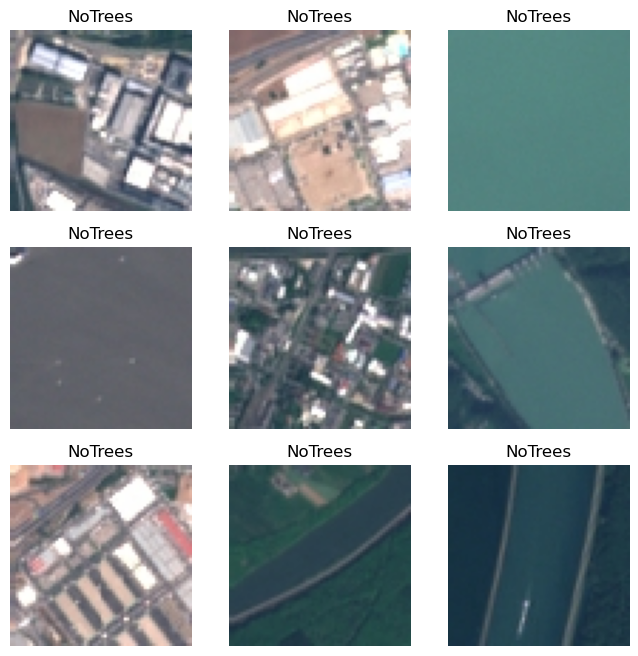

In [4]:
#show first 9 images and labels from the training set:
class_names = training.class_names

plt.figure(figsize=(8, 8))
for images, labels in training.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
        plt.axis("off")

In [5]:
#split the validation dataset into validation and test datasets
val_batches = tf.data.experimental.cardinality(validation)
test_dataset = validation.take(val_batches // 5)
validation = validation.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 104
Number of test batches: 26


In [7]:
# performance configuration: Use buffered prefetching to load images from disk
AUTOTUNE = tf.data.AUTOTUNE

training = training.prefetch(buffer_size=AUTOTUNE)
validation = validation.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

The MobileNetV2 model expects pixel values from [-1,1] instead of the [0,255] that the images are in currently. So I will first need to rescale them:

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
# Create the base model from the pre-trained model MobileNet V2
img_size = (64,64)
img_shape = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
# convert each image into a bblock of features
image_batch, label_batch = next(iter(training))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 2, 2, 1280)


In [11]:
# Freeze the convolutional base before compiling and training the model. This prevents the weights
# in a given layer from being updated before training. 
base_model.trainable = False

In [12]:
# Let's see the base model's summary
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 8, 8, 144)   576         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 8, 8, 144)    0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 8, 8, 32)     4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 8, 8, 32)    128         ['block_3_project[0][0]']        
 lization)                                                                                        
          

                                                                                                  
 block_7_expand_relu (ReLU)     (None, 4, 4, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 4, 4, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 4, 4, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_depthwise_relu (ReLU)  (None, 4, 4, 384)    0           ['block_7_depthwise_BN[0][0]']   
          

 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 4, 4, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 4, 4, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 4, 4, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_depthwise (DepthwiseC  (None, 4, 4, 576)   5184        ['block_11_expand_relu[0][0]']   
 onv2D)   

 block_14_depthwise_relu (ReLU)  (None, 2, 2, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 2, 2, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 2, 2, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 2, 2, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
                                                                                                  
 block_15_

In [13]:
# generate predictions from the block of features by averaging over the 2x2 spatial locations, 
# using a GlobalAveragePooling2D layer to convert the features to a single 
# 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [14]:
# Apply a Dense layer to convert these features into a single prediction per image. 
# no activation function here because this prediction will be treated as a logit (raw prediction value)
#Positive numbers predict class 1, negative numbers class 0.

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [15]:
#build a model with rescaling, basemodel, and feature extrator layers
inputs = tf.keras.Input(shape=(64, 64, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
# compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [18]:
len(model.trainable_variables)

2

The 2.2 million MobileNet parameters are frozen but there are about 1200 trainable parameters in the Dense layer (divided between 2 TensorFlow variable objects -  weights and biases).

In [19]:
#train the model for 10 epochs
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

104/104 [==============================] - 7s 48ms/step - loss: 0.7545 - accuracy: 0.5436
initial loss: 0.75
initial accuracy: 0.54


In [20]:
from time import time
start = time()

history = model.fit(training,
                    epochs=initial_epochs,
                    validation_data=validation)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 1/10
517/517 [==============================] - 42s 76ms/step - loss: 0.5190 - accuracy: 0.7182 - val_loss: 0.3459 - val_accuracy: 0.8115
Epoch 2/10
517/517 [==============================] - 43s 82ms/step - loss: 0.3392 - accuracy: 0.8306 - val_loss: 0.2669 - val_accuracy: 0.8800
Epoch 3/10
517/517 [==============================] - 35s 68ms/step - loss: 0.2798 - accuracy: 0.8727 - val_loss: 0.2322 - val_accuracy: 0.8939
Epoch 4/10
517/517 [==============================] - 31s 59ms/step - loss: 0.2427 - accuracy: 0.8941 - val_loss: 0.2032 - val_accuracy: 0.9145
Epoch 5/10
517/517 [==============================] - 34s 66ms/step - loss: 0.2209 - accuracy: 0.9091 - val_loss: 0.1881 - val_accuracy: 0.9206
Epoch 6/10
517/517 [==============================] - 35s 67ms/step - loss: 0.2041 - accuracy: 0.9165 - val_loss: 0.1773 - val_accuracy: 0.9327
Epoch 7/10
517/517 [==============================] - 35s 67ms/step - loss: 0.1938 - accuracy: 0.9206 - val_loss: 0.1664 - val_accuracy:

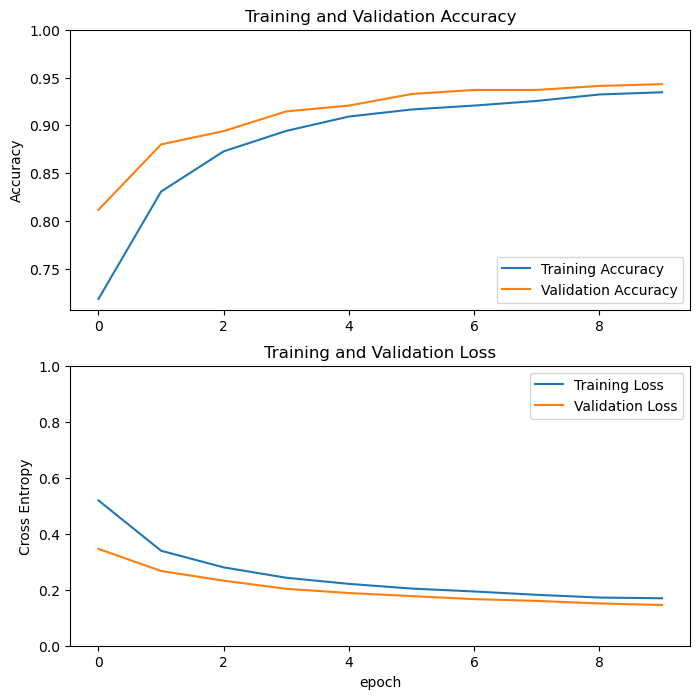

In [21]:
#plot training and validation learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In the feature extraction model, I only trained a few new layers on top of the MobileNetV2 model, and the weights of the pre-trained model were not updated during training. Next, I will take a look at fine-tuning the weights of the top layers of the pretrained model also. This will change the weights being tuned from generic feature maps to maps of features more specifically associated with the forest satellite image dataset.

In [22]:
# I will unfreeze the base model so that I can fine tune a few top layers. 
base_model.trainable = True

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [24]:
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Before compiling the new model, I will change the learning rate to 0.00001. A lower learning rate is important to not overfit too quickly when training a much larger model than the previous feature extraction model.

In [25]:
#use a lower learning rate

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [27]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

start = time()

history_finetuned = model.fit(training,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 10/20
517/517 [==============================] - 49s 84ms/step - loss: 0.1477 - accuracy: 0.9410 - val_loss: 0.1181 - val_accuracy: 0.9570
Epoch 11/20
517/517 [==============================] - 36s 70ms/step - loss: 0.1246 - accuracy: 0.9522 - val_loss: 0.1050 - val_accuracy: 0.9618
Epoch 12/20
517/517 [==============================] - 35s 68ms/step - loss: 0.1074 - accuracy: 0.9567 - val_loss: 0.0940 - val_accuracy: 0.9661
Epoch 13/20
517/517 [==============================] - 37s 72ms/step - loss: 0.0924 - accuracy: 0.9648 - val_loss: 0.0912 - val_accuracy: 0.9685
Epoch 14/20
517/517 [==============================] - 41s 79ms/step - loss: 0.0899 - accuracy: 0.9653 - val_loss: 0.0830 - val_accuracy: 0.9709
Epoch 15/20
517/517 [==============================] - 44s 84ms/step - loss: 0.0785 - accuracy: 0.9719 - val_loss: 0.0822 - val_accuracy: 0.9709
Epoch 16/20
517/517 [==============================] - 38s 73ms/step - loss: 0.0721 - accuracy: 0.9741 - val_loss: 0.0775 - val_ac

In [27]:
def plot_learning_curve(history):
    tr_loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Plot the training and validation loss
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.plot(tr_loss, label="Training Loss", color='blue')
    plt.plot(val_loss, label="Validation Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim([0,1.0])
    plt.legend()
    plt.title("Training and Validation Loss")
    
    # Plot the train and val accuracy
    plt.subplot(1,2,2)
    plt.plot(tr_acc, label="Training Accuracy", color='blue')
    plt.plot(val_acc, label="Validation Accuracy", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0.8,1])
    plt.legend()
    plt.title("Training and Validation Accuracy")         

    # Show the figure
    plt.show()

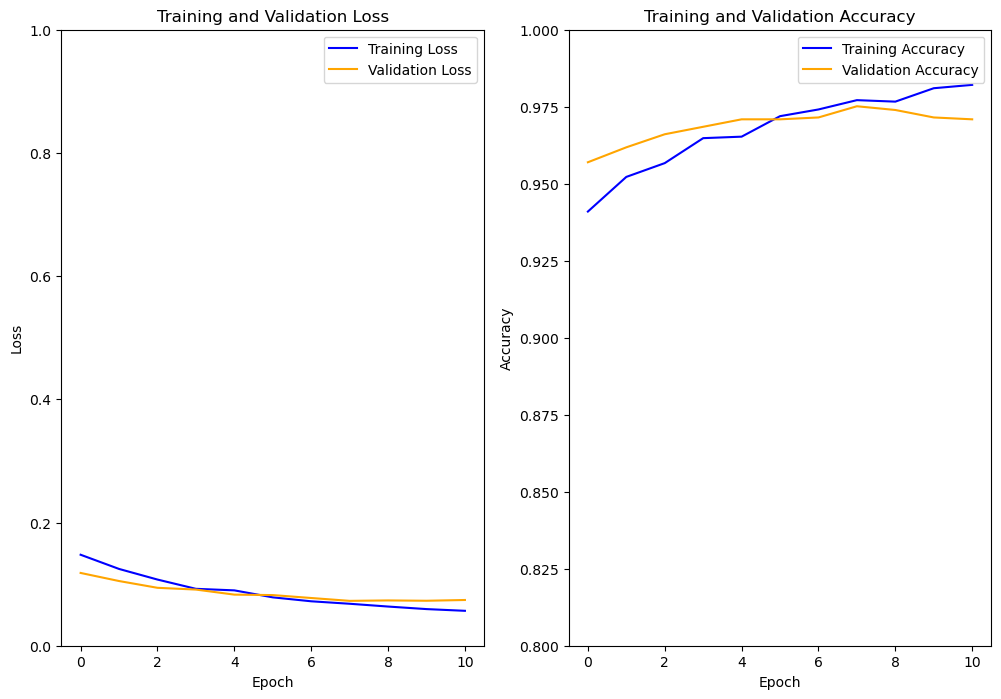

In [29]:
fine_tuned_plots = plot_learning_curve(history_finetuned)

So validation loss and accuracy are definitely improved from the feature extractor model. But let's try fine tuning more top layers than just the last 4, maybe around 15 top layers, and see if the model improves even more and how much extra time that takes to train.

In [22]:
base_model.trainable = True

In [23]:
# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 64, 64, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 2, 2, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [25]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

start = time()

history_finetuned_2 = model.fit(training,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation)

end = time()

elapsed = end - start

print(f"Elapsed Time = {elapsed} seconds")

Epoch 10/20
517/517 [==============================] - 48s 87ms/step - loss: 0.1351 - accuracy: 0.9476 - val_loss: 0.0924 - val_accuracy: 0.9655
Epoch 11/20
517/517 [==============================] - 47s 91ms/step - loss: 0.0995 - accuracy: 0.9624 - val_loss: 0.0866 - val_accuracy: 0.9697
Epoch 12/20
517/517 [==============================] - 50s 97ms/step - loss: 0.0778 - accuracy: 0.9689 - val_loss: 0.0900 - val_accuracy: 0.9624
Epoch 13/20
517/517 [==============================] - 51s 99ms/step - loss: 0.0637 - accuracy: 0.9765 - val_loss: 0.0832 - val_accuracy: 0.9721
Epoch 14/20
517/517 [==============================] - 46s 89ms/step - loss: 0.0553 - accuracy: 0.9803 - val_loss: 0.0796 - val_accuracy: 0.9745
Epoch 15/20
517/517 [==============================] - 46s 90ms/step - loss: 0.0461 - accuracy: 0.9849 - val_loss: 0.0711 - val_accuracy: 0.9764
Epoch 16/20
517/517 [==============================] - 45s 87ms/step - loss: 0.0398 - accuracy: 0.9872 - val_loss: 0.0705 - val_ac

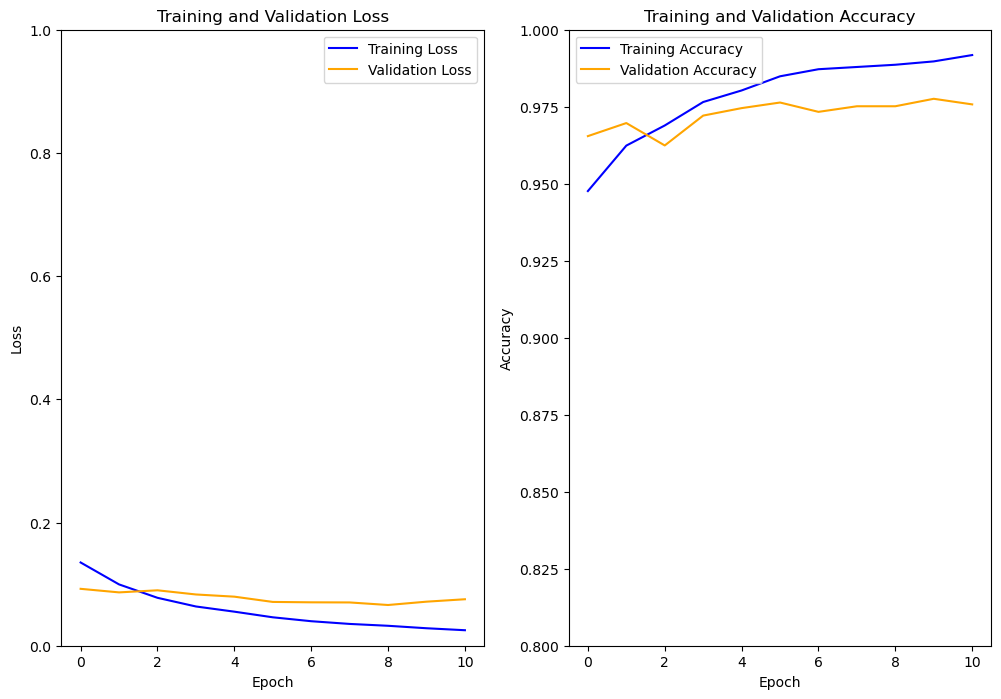

In [28]:
fine_tuned_plots_2 = plot_learning_curve(history_finetuned_2)

So fine-tuning the weights of the top 14 layers leads to training and validation accuracy just under 98% and validation loss around 0.06 to 0.07. This takes about 10 minutes of training on a single machine with about 13 GB of available RAM.

In [106]:
model.save("Forest_MobileNetV2_Transfer_Model")

INFO:tensorflow:Assets written to: Forest_MobileNetV2_Transfer_Model\assets


INFO:tensorflow:Assets written to: Forest_MobileNetV2_Transfer_Model\assets


Below is a display of some of the images that the model mislabeled from the test set.

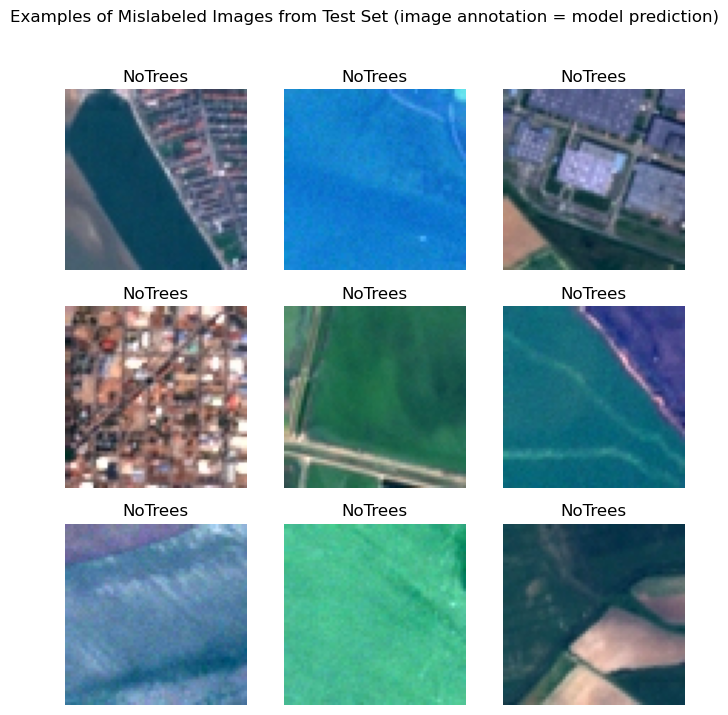

In [31]:
mislabeled_img = []
mislabeled_pred = []
mislabeled_class = []
preds = []
test_labels = []
images=[]

# There are 26 batches in the test set. 
# Take enough batches to be sure to get at least 9 mislabeled images.

for imgs, labels in test_dataset.take(26): 
    
    batch_preds = model.predict(imgs, verbose = 0)

    test_labels = [int(x) for x in test_labels]

    # Apply a sigmoid since the model returns logits
    batch_preds = tf.nn.sigmoid(batch_preds)
    batch_preds = tf.where(batch_preds < 0.5, 0, 1) #assign class 0 if probability less than 0.5, otherwise class 1
    batch_preds = list(batch_preds.numpy()) #to get predictions in same format as labels
    preds.extend(batch_preds)
    test_labels.extend(labels)

    for j in range(len(imgs)):
        images.append(tf.keras.utils.array_to_img(imgs[j]))

index_list = [] 

for i in range(len(test_labels)):
    if test_labels[i] != preds[i]:
        index_list.append(i)
        mislabeled_pred.append(preds[i])
        mislabeled_class.append(test_labels[i])

#print(f"Predicted Label:    {mislabeled_pred}")
#print(f"Actual Class Label: {mislabeled_class}")

plt.figure(figsize=(8, 8))
for i in range(len(index_list)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[index_list[i]])
    plt.title(class_names[np.argmax(mislabeled_class[i], axis=None, out=None)])
    plt.axis("off")
    plt.suptitle("Examples of Mislabeled Images from Test Set (image annotation = model prediction)")

It is evident from the example mislabeled images that the model has a hard time correctly predicting Trees in the case of a solid blue image, although these may be incorrectly color processed. The other type of image giving the model trouble are those images that are mostly non-natural surfaces like buildings and roads, that happend to also have some trees in them. That is actually good news, because if this type of mislabeling makes up a significant portion of the mislabeled cases, the meaningful accuracy of the model is actually higher. This is because the real-world use case for such a model would likely not be trying to predict whether there are trees in an urban area. Such a specific use-case would likely need a specialty training set. Below I will reload the saved final model and evaluate loss/accuracy on the entire test dataset.

In [107]:
# use the saved model to reconstruct the model identically.
reconstructed_model = keras.models.load_model("Forest_MobileNetV2_Transfer_Model")


In [108]:
predictions = reconstructed_model.evaluate(x=test_dataset, return_dict=True)
# Apply a sigmoid since the model returns logits
#predictions = tf.nn.sigmoid(predictions)
#predictions = tf.where(predictions < 0.5, 0, 1) #assign class 0 if probability less than 0.5, otherwise class 1
#predictions = list(predictions.numpy())


26/26 [==============================] - 2s 59ms/step - loss: 0.1009 - accuracy: 0.9712


So, the final model achieves about 97% accuracy on the rather small test set, which is just slightly worse than on the validation set.